In [1]:
# 首先 import 一些主要的包
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import torch

# 画图使用
%matplotlib inline

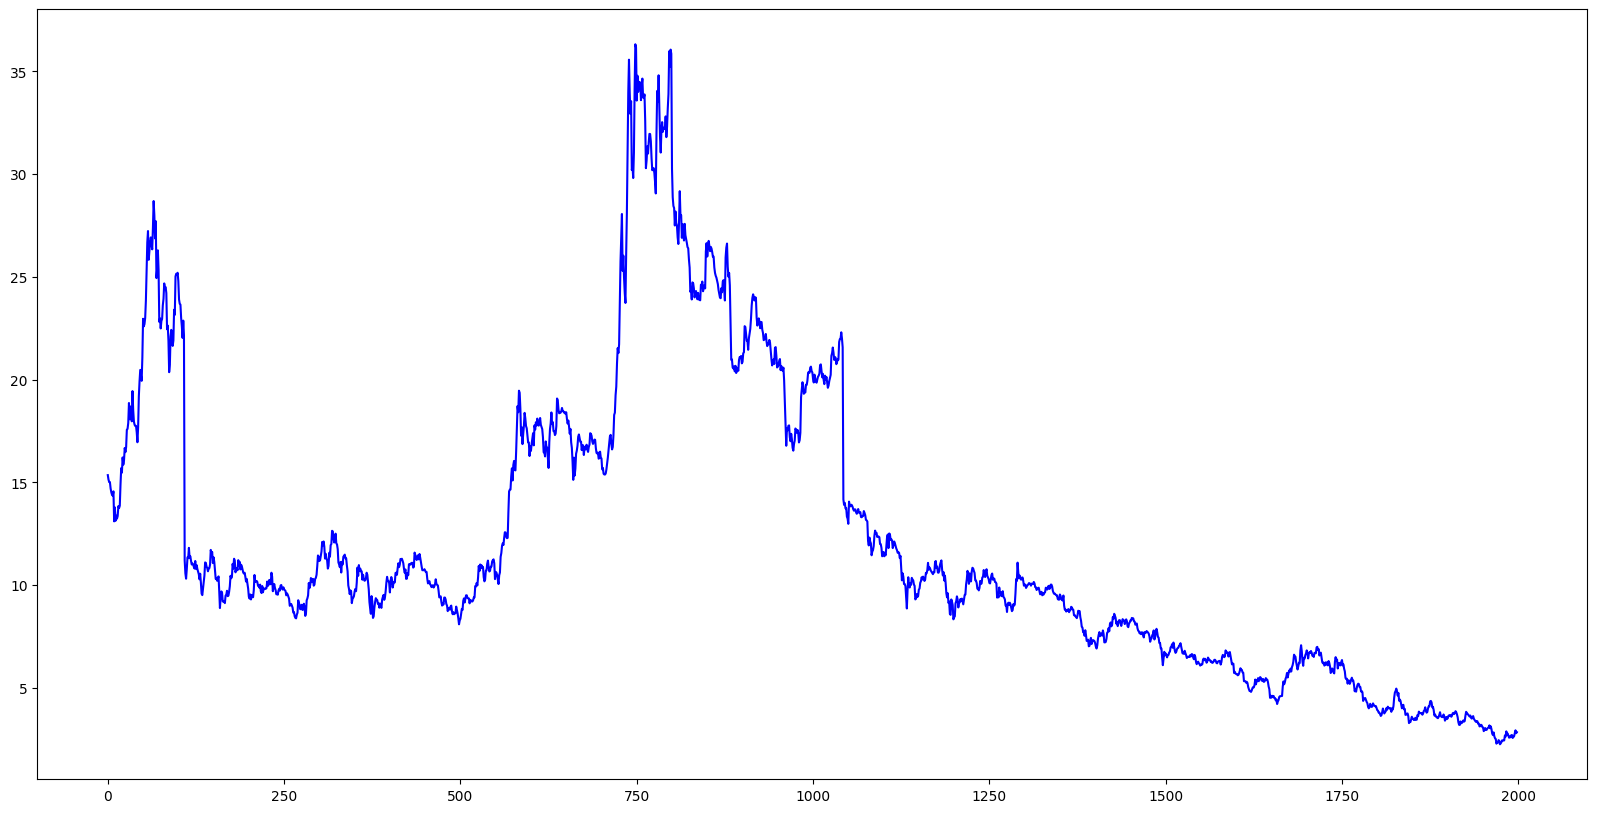

In [2]:
data = np.load('train_data.npy')
plt.figure(figsize=(20,10))
plt.plot(data,c='blue')
plt.show()

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(np.array([0, 300]).reshape(-1, 1))

In [4]:
# 生成题目所需的训练集合
def generate_data(data):
    
    # 记录 data 的长度
    n = data.shape[0]
    
    # 目标是生成可直接用于训练和测试的 x 和 y
    x = []
    y = []
        
    # 建立 (14 -> 1) 的 x 和 y
    for i in range(15, n):
        x.append(data[i-15:i-1])
        y.append(data[i-1])
            
    # 转换为 numpy 数组
    x = np.array(x)
    y = np.array(y)
        
    return x,y

In [5]:
# 生成 train valid test 集合，以供训练所需
def generate_training_data(x, y):
    # 样本总数
    num_samples = x.shape[0]
    # 测试集大小
    num_test = round(num_samples * 0.2)
    # 训练集大小
    num_train = round(num_samples * 0.7)
    # 校验集大小
    num_val = num_samples - num_test - num_train
    
    # 训练集拥有从 0 起长度为 num_train 的样本
    x_train, y_train = x[:num_train], y[:num_train]
    # 校验集拥有从 num_train 起长度为 num_val 的样本
    x_val, y_val = (
        x[num_train: num_train + num_val],
        y[num_train: num_train + num_val],
    )
    # 测试集拥有尾部 num_test 个样本
    x_test, y_test = x[-num_test:], y[-num_test:]
    
    # 返回这些集合
    return x_train, y_train, x_val, y_val, x_test, y_test

In [6]:
# 获取数据中的 x, y
x,y = generate_data(data)
# 将 x,y 转换乘 tensor ， Pytorch 模型默认的类型是 float32
x = torch.tensor(x)
y = torch.tensor(y)
# 将 y 转化形状
y = y.view(y.shape[0],1)
# 对 x, y 进行 minmaxscale
x_scaled = scaler.transform(x.reshape(-1,1)).reshape(-1,14)
y_scaled = scaler.transform(y)

x_scaled = torch.tensor(x_scaled, dtype=torch.float32)
y_scaled = torch.tensor(y_scaled, dtype=torch.float32)
x_train, y_train, x_val, y_val, x_test, y_test = generate_training_data(x_scaled, y_scaled)

In [7]:
# 建立一个自定 Dataset
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
 
    def __getitem__(self, item):
        return self.x[item], self.y[item]
 
    def __len__(self):
        return len(self.x)
# 建立训练数据集、校验数据集和测试数据集
train_data = MyDataset(x_train,y_train)
valid_data = MyDataset(x_val,y_val)
test_data = MyDataset(x_test,y_test)
# 规定批次的大小
batch_size = 4096

# 创建对应的 DataLoader
train_iter = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# 校验集和测试集的 shuffle 是没有必要的，因为每次都会全部跑一遍
valid_iter = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [8]:
def compute_mae(y_hat, y):
    '''
    :param y: 标准值
    :param y_hat: 用户的预测值
    :return: MAE 平均绝对误差 mean(|y*-y|)
    '''
    return torch.mean(torch.abs(y_hat - y))

def compute_mape(y_hat, y):
    '''
    :param y: 标准值
    :param y_hat: 用户的预测值
    :return: MAPE 平均百分比误差 mean(|y*-y|/y)
    '''
    return torch.mean(torch.abs(y_hat - y)/y)
def evaluate_accuracy(data_iter, model):
    '''
    :param data_iter: 输入的 DataLoader
    :param model: 用户的模型
    :return: 对应的 MAE 和 MAPE
    '''
    # 初始化参数
    mae_sum, mape_sum, n = 0.0, 0.0, 0
    
    # 对每一个 data_iter 的每一个 x,y 进行计算
    for x, y in data_iter:
        
        # 如果运行在 GPU 上，需要将内存中的 x 拷贝到显存中
        if (torch.cuda.is_available()):
            x=x.cuda()
            
        # 计算模型得出的 y_hat
        y_hat = model(x)
        
        # 将 y_hat 逆归一化，这里逆归一化需要将数据转移到 CPU 才可以进行
        y_hat_real = torch.from_numpy(scaler.inverse_transform(np.array(y_hat.detach().cpu()).reshape(-1,1)).reshape(y_hat.shape))
        y_real = torch.from_numpy(scaler.inverse_transform(np.array(y.reshape(-1,1))).reshape(y.shape))
        
        # 计算对应的 MAE 和 RMSE 对应的和，并乘以 batch 大小
        mae_sum += compute_mae(y_hat_real,y_real) * y.shape[0]
        mape_sum += compute_mape(y_hat_real,y_real) * y.shape[0]
        
        # n 用于统计 DataLoader 中一共有多少数量
        n += y.shape[0]
        
    # 返回时需要除以 batch 大小，得到平均值
    return mae_sum / n, mape_sum / n

In [9]:
# 输入的数量是前 14 个交易日的收盘价
num_inputs = 14
# 输出是下一个交易日的收盘价
num_outputs = 1
# 隐藏层的个数
num_hiddens = 16 
# 建立一个稍微复杂的 LSTM 模型
class LSTMNet(torch.nn.Module):
    def __init__(self, num_hiddens, num_outputs):
        super(LSTMNet, self).__init__()
        self.hidden_size = num_hiddens
        self.rnn = torch.nn.LSTM(1,self.hidden_size,1,batch_first=True)
        # 线性层
        self.dense = torch.nn.Linear(self.hidden_size, 1)

        # 前向传播函数，这是一个拼接的过程，使用大量变量是为了避免混淆，不做过多讲解
    def forward(self, x): 
        x = x.unsqueeze(-1)
        h, _ = self.rnn(x)
        y = self.dense(h)[:,-1,:]
        return y

In [10]:
class LinearNet(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet, self).__init__()
        #线性层
        self.linear = torch.nn.Linear(num_inputs, 32)
        self.linear2 = torch.nn.Linear(32, 8)
        self.linear3 = torch.nn.Linear(8, num_outputs)
        # dropout 层，这里的参数指 dropout 的概率
        self.dropout = torch.nn.Dropout(0.3)
        self.dropout2 = torch.nn.Dropout(0.5)
        # ReLU 层
        self.gelu = torch.nn.GELU()
    # 前向传播函数
    def forward(self, x): # x shape: (batch, 14)
        x = self.linear(x)
        x = self.dropout(x)
        x = self.gelu(x)
        x = self.linear2(x)
        x = self.dropout2(x)
        x = self.gelu(x)
        y = self.linear3(x)
        return y

In [11]:
class LinearOne(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearOne, self).__init__()
        #线性层
        self.linear = torch.nn.Linear(num_inputs, num_outputs)
    # 前向传播函数
    def forward(self, x): # x shape: (batch, 14)
        y = self.linear(x)
        return y

In [12]:
def compute_mae(y_hat, y):
    '''
    :param y: 标准值
    :param y_hat: 用户的预测值
    :return: MAE 平均绝对误差 mean(|y*-y|)
    '''
    return torch.mean(torch.abs(y_hat - y))

def compute_mape(y_hat, y):
    '''
    :param y: 标准值
    :param y_hat: 用户的预测值
    :return: MAPE 平均百分比误差 mean(|y*-y|/y)
    '''
    return torch.mean(torch.abs(y_hat - y)/y)
def my_loss_func(y_hat, y):
    return compute_mae(y_hat, y)+compute_mape(y_hat, y)

In [13]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = torch.nn.MSELoss()
model = LinearOne(num_inputs,num_outputs)
model.load_state_dict(torch.load('linear.pt'))
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 5000

In [14]:
def train_model(model, train_iter, valid_iter, loss, num_epochs, params=None, optimizer=None):
    
    # 用于绘图用的信息
    train_losses, valid_losses, train_maes, train_mapes, valid_maes, valid_mapes = [], [], [], [], [], []
    
    # 循环 num_epochs 次
    for epoch in range(num_epochs):
        # 初始化参数
        train_l_sum, n = 0.0, 0
        # 初始化时间
        start = time.time()
        # 模型改为训练状态，如果使用了 dropout, batchnorm 之类的层时，训练状态和评估状态的表现会有巨大差别
        model.train()
        
        # 对训练数据集的每个 batch 执行
        for x, y in train_iter:
            
            # 如果使用了 GPU 则拷贝进显存
            if (torch.cuda.is_available()):
                x,y = x.cuda(),y.cuda()
            
            # 计算 y_hat
            y_hat = model(x)
            
            # 计算损失
            l = loss(y_hat, y).mean()
            #l = my_loss_func(y_hat, y)
            # 梯度清零
            optimizer.zero_grad()
            
            # L1 正则化
            #for param in params:
                #l += torch.sum(torch.abs(param))
            
            # L2 正则化可以在 optimizer 上加入 weight_decay 的方式加入

            # 求好对应的梯度
            l.backward()

            # 执行一次反向传播
            optimizer.step()

            # 对 loss 求和（在下面打印出来）
            train_l_sum += l.item() * y.shape[0]
            
            # 计数一共有多少个元素
            n += y.shape[0]
            
        # 模型开启预测状态
        model.eval()
        
        # 同样的，我们可以计算验证集上的 loss
        valid_l_sum, valid_n = 0, 0
        for x, y in valid_iter:
            # 如果使用了 GPU 则拷贝进显存
            if (torch.cuda.is_available()):
                x,y = x.cuda(),y.cuda()
            
            # 计算 y_hat
            y_hat = model(x)
            
            # 计算损失
            l = loss(y_hat, y).mean()

            # 对 loss 求和（在下面打印出来）
            valid_l_sum += l.item() * y.shape[0]
            
            # 计数一共有多少个元素
            valid_n += y.shape[0]
        
        # 对验证集合求指标
        # 这里训练集其实可以在循环内高效地直接算出，这里为了代码的可读性牺牲了效率
        train_mae, train_mape = evaluate_accuracy(train_iter, model)
        valid_mae, valid_mape = evaluate_accuracy(valid_iter, model)
        if (epoch+1) % 50 == 0:
            print('epoch %d, train loss %.6f, valid loss %.6f, train mae %.6f, mape %.6f, valid mae %.6f,mape %.6f, time %.2f sec'
              % (epoch + 1, train_l_sum / n, valid_l_sum / valid_n, train_mae, train_mape, valid_mae, valid_mape, time.time() - start))
        
        # 记录绘图有关的信息
        train_losses.append(train_l_sum / n)
        valid_losses.append(valid_l_sum / valid_n)
        train_maes.append(train_mae)
        train_mapes.append(train_mape)
        valid_maes.append(valid_mae)
        valid_mapes.append(valid_mape)
        
    # 返回一个训练好的模型和用于绘图的集合
    return model, (train_losses, valid_losses, train_maes, train_mapes, valid_maes, valid_mapes)
model, (train_losses, valid_losses, train_maes, train_mapes, valid_maes, valid_mapes) = train_model(model, train_iter, test_iter, loss, epochs, model.parameters(), optimizer)

epoch 50, train loss 0.000008, valid loss 0.000000, train mae 0.450701, mape 0.029259, valid mae 0.157882,mape 0.036954, time 0.01 sec
epoch 100, train loss 0.000007, valid loss 0.000000, train mae 0.447646, mape 0.029138, valid mae 0.163825,mape 0.038540, time 0.01 sec
epoch 150, train loss 0.000007, valid loss 0.000000, train mae 0.442712, mape 0.028820, valid mae 0.161704,mape 0.038003, time 0.01 sec
epoch 200, train loss 0.000007, valid loss 0.000000, train mae 0.437338, mape 0.028476, valid mae 0.159562,mape 0.037464, time 0.01 sec
epoch 250, train loss 0.000007, valid loss 0.000000, train mae 0.431808, mape 0.028121, valid mae 0.157363,mape 0.036915, time 0.01 sec
epoch 300, train loss 0.000007, valid loss 0.000000, train mae 0.426392, mape 0.027770, valid mae 0.155178,mape 0.036374, time 0.01 sec
epoch 350, train loss 0.000007, valid loss 0.000000, train mae 0.421042, mape 0.027424, valid mae 0.153071,mape 0.035854, time 0.01 sec
epoch 400, train loss 0.000007, valid loss 0.0000

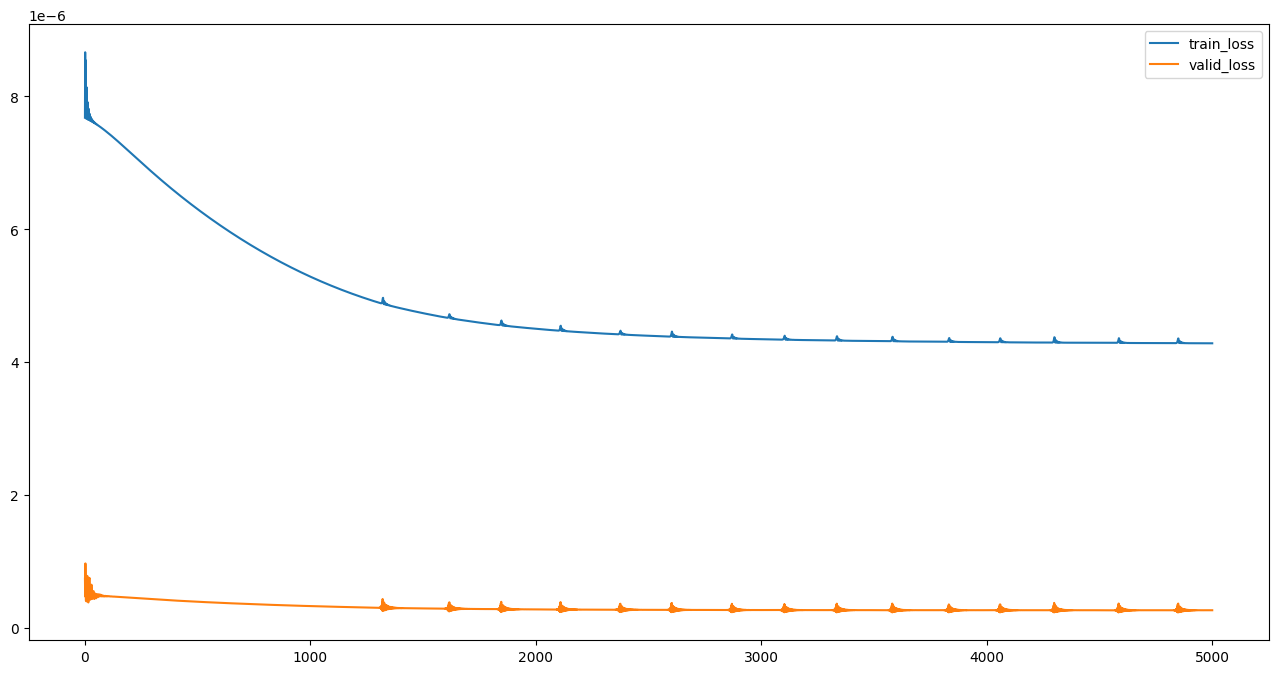

In [15]:
# 新建一个图像
plt.figure(figsize=(16,8))

# 绘制 train_loss 曲线
plt.plot(train_losses, label='train_loss')

# 绘制 valid_loss 曲线
plt.plot(valid_losses, label='valid_loss')

# 展示带标签的图像
plt.legend()
plt.show()

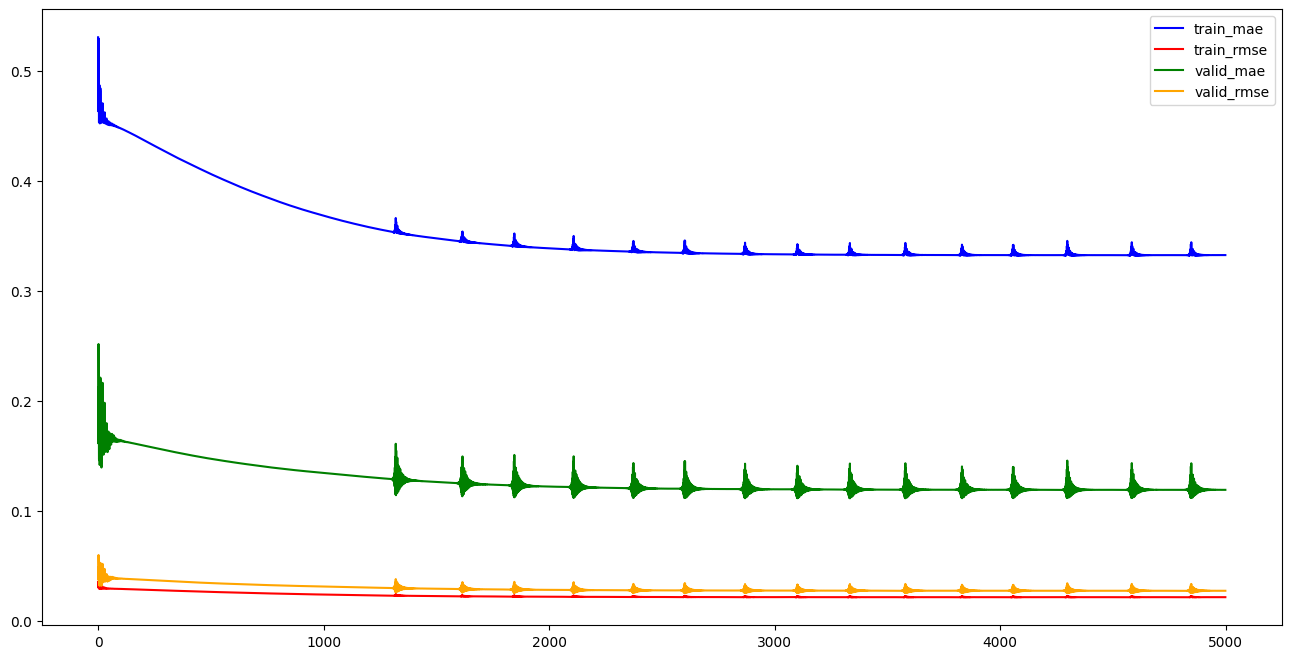

In [16]:
# 新建一个图像
plt.figure(figsize=(16,8))

# 绘画结点
plt.plot(train_maes, c='blue', label='train_mae')

plt.plot(train_mapes, c='red', label='train_rmse')

plt.plot(valid_maes, c='green', label='valid_mae')

plt.plot(valid_mapes, c='orange', label='valid_rmse')

# 展示图像
plt.legend()
plt.show()

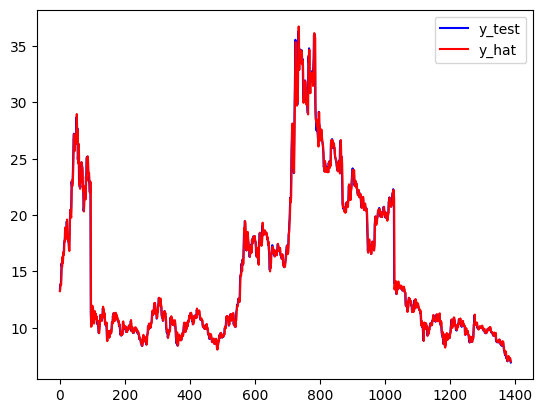

In [17]:
model.eval()
y_hat = model(x_train.to(DEVICE)).detach().to('cpu')
plt.plot(scaler.inverse_transform(y_train.reshape(-1,1)).reshape(-1), c='blue', label='y_test')
plt.plot(scaler.inverse_transform(y_hat.detach().reshape(-1,1)).reshape(-1), c='red', label='y_hat')
plt.legend()
plt.show()

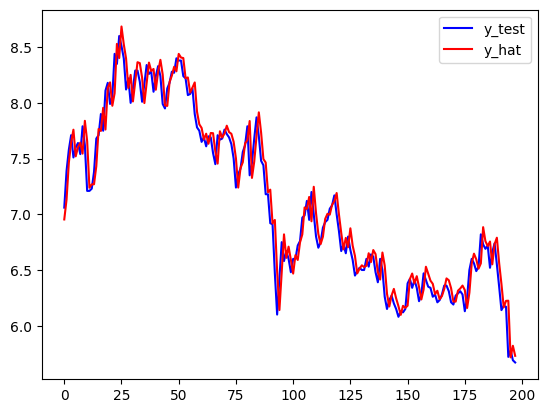

In [18]:
y_hat = model(x_val.to(DEVICE)).detach().to('cpu')
plt.plot(scaler.inverse_transform(y_val.reshape(-1,1)).reshape(-1), c='blue', label='y_test')
plt.plot(scaler.inverse_transform(y_hat.detach().reshape(-1,1)).reshape(-1), c='red', label='y_hat')
plt.legend()
plt.show()

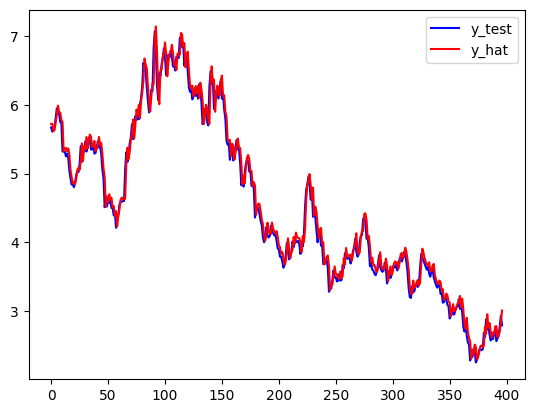

In [19]:
y_hat = model(x_test.to(DEVICE)).detach().to('cpu')
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)).reshape(-1), c='blue', label='y_test')
plt.plot(scaler.inverse_transform(y_hat.detach().reshape(-1,1)).reshape(-1), c='red', label='y_hat')
plt.legend()
plt.show()

In [20]:
model.to('cpu')
torch.save(model.state_dict(), 'linear.pt',_use_new_zipfile_serialization=False)